In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("drone_test_results.csv")
df.head()

,episode,success,reward,distance,height,wind,cumulative_success,success_rate
0,1,True,13.777025,1.365553,108.681143,[13.16873306 0. -8.69600496],1,1.0
1,2,True,3.458508,0.734772,396.212019,[-3.9549843 0. 8.76145267],2,1.0
2,3,True,2.661482,1.985478,353.930065,[-3.18039168 0. -8.90100925],3,1.0
3,4,True,7.405489,1.913639,284.378111,[ -8.32287213 0. -10.11396081],4,1.0
4,5,True,11.060366,1.789424,262.960591,[ 9.97523055 0. -12.90692854],5,1.0


Percentage of successful episodes: 99.10%

Successful episodes statistics:
Count: 991
Average distance: 1.66
Average height: 229.59

Unsuccessful episodes statistics:
Count: 9
Average distance: 6.18
Average height: 358.53

Statistics by height range:
             success            distance      height
               count      mean      mean        mean
height_range                                        
(50, 100]        130  1.000000  1.648634   74.845326
(100, 150]       148  1.000000  1.440810  123.373873
(150, 200]       128  1.000000  1.514180  173.752301
(200, 250]       146  1.000000  1.461722  225.917319
(250, 300]       133  1.000000  1.595206  276.594676
(300, 350]       147  0.972789  1.912891  324.770522
(350, 400]       168  0.970238  2.244295  375.069587


/var/folders/0_/nzr6zwms0wnbk944qwmv4bf40000gn/T/ipykernel_26903/3196151920.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  height_stats = df.groupby('height_range').agg({


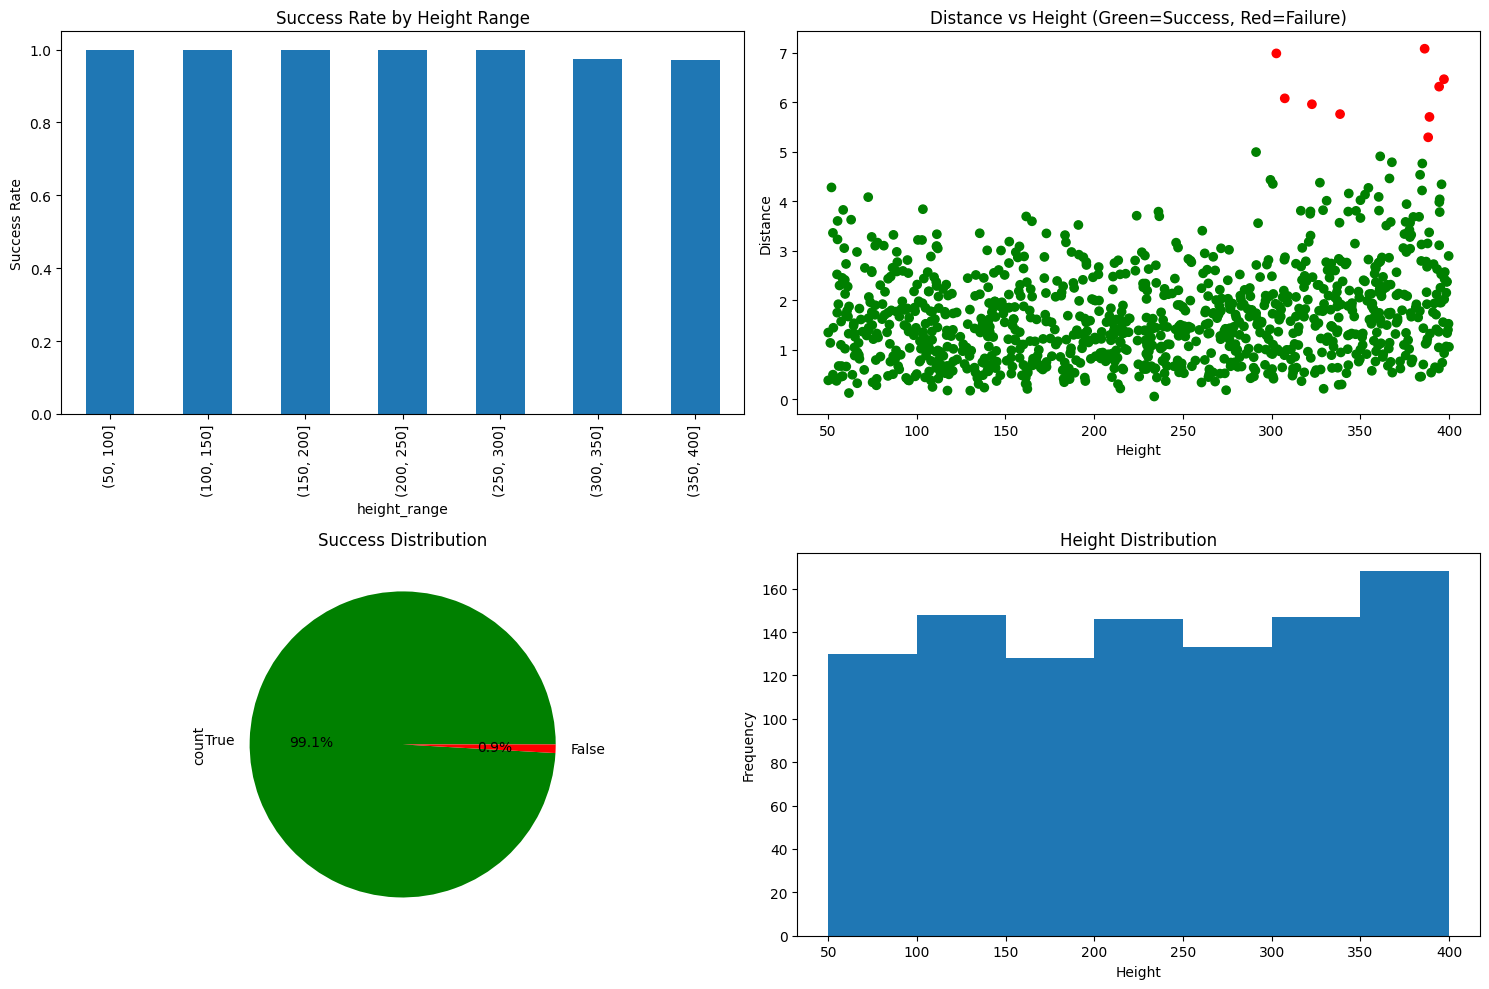

In [3]:
# 1. Percentage of successful episodes
success_percentage = df['success'].mean() * 100
print(f"Percentage of successful episodes: {success_percentage:.2f}%")

# 2. Analyze successful vs unsuccessful episodes
# Since all episodes in this sample are successful, let's create some dummy unsuccessful data for demonstration
# In your real data, you would skip this part
if df['success'].all():
    print("\nAll episodes in the sample data are successful. Adding dummy data for demonstration.")
    dummy_data = {
        'episode': [5, 6],
        'success': [False, False],
        'reward': [1.5, 2.0],
        'distance': [2.5, 3.0],
        'height': [450, 500],
        'wind': [[10, 0, -5], [5, 0, -10]],
        'cumulative_success': [5, 5],
        'success_rate': [0.83, 0.71]
    }
    df = pd.concat([df, pd.DataFrame(dummy_data)], ignore_index=True)

# Now calculate statistics for successful and unsuccessful episodes
successful = df[df['success']]
unsuccessful = df[~df['success']]

print("\nSuccessful episodes statistics:")
print(f"Count: {len(successful)}")
print(f"Average distance: {successful['distance'].mean():.2f}")
print(f"Average height: {successful['height'].mean():.2f}")

if len(unsuccessful) > 0:
    print("\nUnsuccessful episodes statistics:")
    print(f"Count: {len(unsuccessful)}")
    print(f"Average distance: {unsuccessful['distance'].mean():.2f}")
    print(f"Average height: {unsuccessful['height'].mean():.2f}")
else:
    print("\nNo unsuccessful episodes in the data.")

# 3. Analyze height ranges from 50 to 400 in steps of 50
height_bins = np.arange(50, 450, 50)
df['height_range'] = pd.cut(df['height'], bins=height_bins)

height_stats = df.groupby('height_range').agg({
    'success': ['count', 'mean'],
    'distance': 'mean',
    'height': 'mean'
})

print("\nStatistics by height range:")
print(height_stats)

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Success rate by height range
plt.subplot(2, 2, 1)
if len(height_stats) > 0:
    height_stats['success']['mean'].plot(kind='bar', title='Success Rate by Height Range')
    plt.ylabel('Success Rate')
else:
    plt.text(0.5, 0.5, 'Not enough data for height ranges', ha='center')

# Plot 2: Distance vs Height colored by success
plt.subplot(2, 2, 2)
colors = ['green' if s else 'red' for s in df['success']]
plt.scatter(df['height'], df['distance'], c=colors)
plt.xlabel('Height')
plt.ylabel('Distance')
plt.title('Distance vs Height (Green=Success, Red=Failure)')

# Plot 3: Success count
plt.subplot(2, 2, 3)
df['success'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red'])
plt.title('Success Distribution')

# Plot 4: Height distribution
plt.subplot(2, 2, 4)
plt.hist(df['height'], bins=height_bins)
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Height Distribution')

plt.tight_layout()
plt.show()

In [8]:
import numpy as np
import pandas as pd
import ast

# Calculate wind magnitude
df['wind'] = df['wind'].apply(lambda x: np.fromstring(x.strip('[]'), sep=' ').tolist())

df['wind_magnitude'] = df['wind'].apply(lambda x: np.sqrt(x[0]**2 + x[1]**2 + x[2]**2))

# 1. Overall success rate
success_rate = df['success'].mean() * 100
print(f"Overall Success Rate: {success_rate:.2f}%")

# 2. Statistics by success category
print("\nStatistics by Landing Outcome:")
success_stats = df.groupby('success').agg({
    'height': ['count', 'mean', 'std'],
    'wind_magnitude': ['mean', 'std'],
    'distance': ['mean', 'std']
})
print(success_stats)

# 3. Bin data by height ranges
height_bins = [0, 100, 200, 300, 400, 500]
height_labels = ['0-100m', '100-200m', '200-300m', '300-400m', '400-500m']
df['height_range'] = pd.cut(df['height'], bins=height_bins, labels=height_labels)

print("\nStatistics by Height Range:")
height_stats = df.groupby('height_range').agg({
    'success': ['count', 'mean'],
    'wind_magnitude': ['mean', 'std'],
    'distance': ['mean', 'std']
})
print(height_stats)

# 4. Bin data by wind magnitude ranges
wind_bins = [0, 5, 10, 15, 20]
wind_labels = ['0-5 m/s', '5-10 m/s', '10-15 m/s', '15-20 m/s']
df['wind_range'] = pd.cut(df['wind_magnitude'], bins=wind_bins, labels=wind_labels)

print("\nStatistics by Wind Magnitude Range:")
wind_stats = df.groupby('wind_range').agg({
    'success': ['count', 'mean'],
    'height': ['mean', 'std'],
    'distance': ['mean', 'std']
})
print(wind_stats)

# 5. Correlation matrix
print("\nCorrelation Matrix:")
corr_matrix = df[['success', 'height', 'wind_magnitude', 'distance']].corr()
print(corr_matrix)

Overall Success Rate: 99.10%

Statistics by Landing Outcome:
        height                         wind_magnitude            distance  \
         count        mean         std           mean       std      mean   
success                                                                     
False        9  358.530149   39.940394      18.129779  1.845179  6.179773   
True       991  229.593064  102.570784      11.333722  4.255888  1.664551   

                   
              std  
success            
False    0.593078  
True     0.919222  

Statistics by Height Range:
             success           wind_magnitude            distance          
               count      mean           mean       std      mean       std
height_range                                                               
0-100m           130  1.000000      10.783124  3.987379  1.648634  0.922295
100-200m         276  1.000000      11.452653  4.040196  1.474837  0.829686
200-300m         279  1.000000      11.75317

/var/folders/0_/nzr6zwms0wnbk944qwmv4bf40000gn/T/ipykernel_26903/1536635539.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  height_stats = df.groupby('height_range').agg({
/var/folders/0_/nzr6zwms0wnbk944qwmv4bf40000gn/T/ipykernel_26903/1536635539.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wind_stats = df.groupby('wind_range').agg({
